# Coding Discussion 5
Rosey Cao

## Preparation

In [1]:
import pandas as pd
import numpy as np
import pprint as pp # for printing
import scipy.stats as st # for Normal PDF
import sklearn.metrics as m
from sklearn.naive_bayes import GaussianNB

# Plotting libraries 
import matplotlib.pyplot as plt
plt.style.use('ggplot') # Change the style for visual pleasure
import seaborn as sns
from plotnine import *

# Silence warnings 
import warnings
warnings.filterwarnings("ignore")

## Import Data & EDA

In [2]:
df = pd.read_csv('../turnout.csv')

In [3]:
df.head()

,id,age,educate,income,vote,white
0,1,60,14.0,3.3458,1,1
1,2,51,10.0,1.8561,0,1
2,3,24,12.0,0.6304,0,1
3,4,38,8.0,3.4183,1,1
4,5,25,12.0,2.7852,1,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       2000 non-null   int64  
 1   age      2000 non-null   int64  
 2   educate  2000 non-null   float64
 3   income   2000 non-null   float64
 4   vote     2000 non-null   int64  
 5   white    2000 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 93.9 KB


##### Looks like no missing values

<Figure size 1500x1500 with 0 Axes>

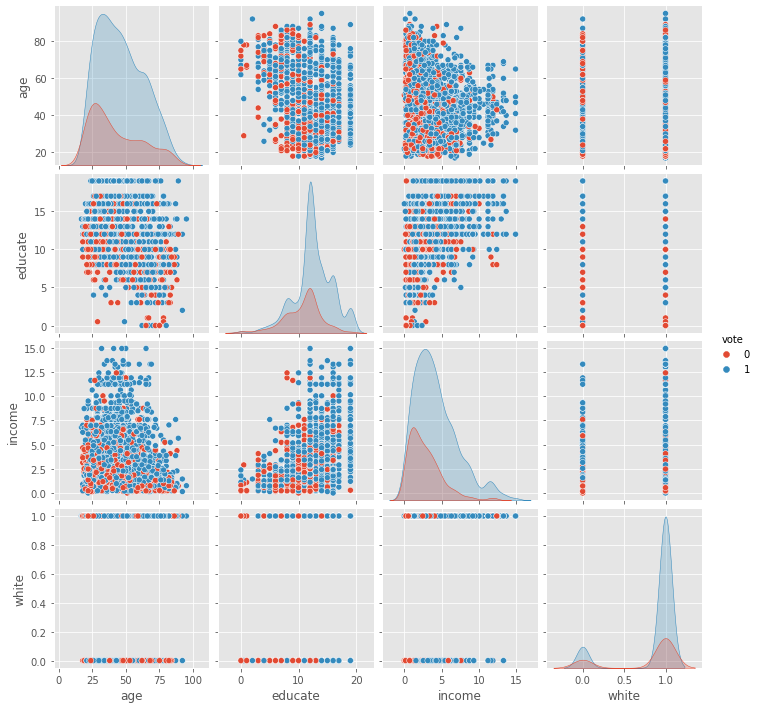

In [5]:
plt.figure(figsize=(10,10),dpi=150)
sns.pairplot(df.drop('id', axis =1), hue="vote")
plt.show()

## Split the data to test and train

In [6]:
# Random pick
train=df.sample(frac=0.8,random_state=123) #random state is a seed value
test=df.drop(train.index)

In [7]:
# Split and drop id
train = train.reset_index(drop=True).drop('id', axis=1)
test = test.reset_index(drop=True).drop('id', axis=1)

In [8]:
train

,age,educate,income,vote,white
0,26,12.0,1.6049,0,1
1,35,14.0,8.7517,1,1
2,17,14.0,6.7838,1,1
3,24,16.0,6.7838,1,1
4,27,12.0,4.8901,0,1
...,...,...,...,...,...
1595,32,8.0,3.5800,0,1
1596,76,11.0,1.2868,1,1
1597,65,9.0,2.3866,1,1
1598,47,12.0,3.7435,1,1


## Build the Naive Bayes Classifier

In [9]:
#####################################
###Setup for Categorical variables###
#####################################

### For categorical(Build the dictionary)
def calc_probs(data,outcome_var=""):
    '''
    Function calculates the class and conditional probabilities in 
    the binary data. 
    
    Note that I'm using dictionaries with tuple keys to keep
    track of the variable, it's val, and the outcome, which we're conditioning on. 
    '''
    # Generate empty dictionary containers.
    class_probs = {};cond_probs = {}
    # Locate all variables that are not the outcome.
    vars = [v for v in data.columns if v != outcome_var]
    # iterate through the class outcomes
    for y, d in data.groupby(outcome_var): 
        # calculate the class probabilities
        class_probs.update({y: d.shape[0]/data.shape[0]})
        for v in vars:
            # calculate the conditional probabilities for each variable given the class.
            pr = d[v].sum()/d.shape[0]
            cond_probs[(v,1,y)] = pr 
            cond_probs[(v,0,y)] = 1 - pr
    return class_probs, cond_probs

### Find the probaility depending on the dictionary
def predict_cat(data, class_probs, cond_probs):
    '''
    Function calculates the conditiona probability for membership into each class.
    Then returns both the probabilities and the most likely class. 
    '''
    store_preds = []
    for i,row in data.iterrows():
        pr_1 = 1; pr_0 = 1
        for j in range(1,len(row.index)):
            pr_0 *= cond_probs[(row.index[j],row.values[j],0)]
            pr_1 *= cond_probs[(row.index[j],row.values[j],1)]     
        pr_0 *= class_probs[0]
        pr_1 *= class_probs[1]
        store_preds.append([pr_0,pr_1,max([(pr_0,0),(pr_1,1)])[1]])
    return pd.DataFrame(store_preds,columns=["pr_0","pr_1","pred"])

#####################################
###Setup for Continuous variables ###
#####################################

def predict_cont(data,dist_locs):
    store_preds = []
    for i,row in data.iterrows():
        
        # Get the predictions using a Gaussan distribution
        pr_0 = 1; pr_1 = 1
        for j in range(1,len(row)):
            pr_0 *= st.norm(dist_locs[(row.index[j],0)]['mean'],
                            dist_locs[(row.index[j],0)]['sd']).pdf(row.values[j])
            pr_1 *= st.norm(dist_locs[(row.index[j],1)]['mean'], 
                            dist_locs[(row.index[j],1)]['sd']).pdf(row.values[j])
        pr_0 *= pr_y0
        pr_1 *= pr_y1
        
        # Assign the class designation to the highest probability
        if pr_0 >= pr_1:
            class_pred = 0
        else:
            class_pred = 1
            
        store_preds.append([pr_0,pr_1,class_pred])
        
    return pd.DataFrame(store_preds,columns=["pr_0","pr_1","pred"])

In [10]:
### Filter categorical data
train_cat = train.filter(['vote','white'])
train_cat

,vote,white
0,0,1
1,1,1
2,1,1
3,1,1
4,0,1
...,...,...
1595,0,1
1596,1,1
1597,1,1
1598,1,1


In [11]:
# Calculate pr
class_probs, cond_probs = calc_probs(train_cat, outcome_var= 'vote')
# Print
print("class probabilities",end="\n\n")
pp.pprint(class_probs)
print("\n")
print("conditional probabilities",end="\n\n")
pp.pprint(cond_probs)

class probabilities

{0: 0.255625, 1: 0.744375}


conditional probabilities

{('white', 0, 0): 0.2102689486552567,
 ('white', 0, 1): 0.12762384550797645,
 ('white', 1, 0): 0.7897310513447433,
 ('white', 1, 1): 0.8723761544920235}


In [12]:
# Predictions for categorical variables
preds_cat = predict_cat(train_cat, class_probs, cond_probs)
preds_cat.head()

,pr_0,pr_1,pred
0,0.201875,0.649375,1
1,0.201875,0.649375,1
2,0.201875,0.649375,1
3,0.201875,0.649375,1
4,0.201875,0.649375,1


In [13]:
# Get a general sense of predictions(only on cat)
preds_cat.pred.value_counts()

1    1600
Name: pred, dtype: int64

In [14]:
# Filter continuous variables
train_cont = train.filter(['vote','age','educate','income'])
train_cont

,vote,age,educate,income
0,0,26,12.0,1.6049
1,1,35,14.0,8.7517
2,1,17,14.0,6.7838
3,1,24,16.0,6.7838
4,0,27,12.0,4.8901
...,...,...,...,...
1595,0,32,8.0,3.5800
1596,1,76,11.0,1.2868
1597,1,65,9.0,2.3866
1598,1,47,12.0,3.7435


In [15]:
# Build the dictionary for continuous variabls
y1 = train_cont.query("vote == 1")
y0 = train_cont.query("vote == 0")

# Class probabilities.
pr_y1 = y1.shape[0]/train_cont.shape[0]
pr_y0 = y0.shape[0]/train_cont.shape[0]

# Collect the mean and standard dev. of each conditional distribution
dist_locs = \
{("age",1):{'mean':y1.age.mean(),'sd':y1.age.std()},
 ("age",0):{'mean':y0.age.mean(),'sd':y0.age.std()},
 ("educate",1):{'mean':y1.educate.mean(),'sd':y1.educate.std()},
 ("educate",0):{'mean':y0.educate.mean(),'sd':y0.educate.std()},
 ("income",1):{'mean':y1.income.mean(),'sd':y1.income.std()},
 ("income",0):{'mean':y0.income.mean(),'sd':y0.income.std()}
}

In [16]:
# Predictions for continuous variables
preds_cont = predict_cont(train_cont, dist_locs)
preds_cont.head()

,pr_0,pr_1,pred
0,0.000068,0.000092,1
1,0.000001,0.000065,1
2,0.000005,0.000040,1
3,0.000003,0.000049,1
4,0.000050,0.000146,1


In [17]:
# Result of predictions(only on cont)
preds_cont.pred.value_counts()

1    1398
0     202
Name: pred, dtype: int64

In [18]:
# Assuming all variables are independent, the overall pr is multiplication of cat and cont
preds_summary = preds_cat.iloc[:,0:2] * preds_cont.iloc[:,0:2]

In [19]:

for i,row in preds_summary.iterrows():
    if row['pr_0'] > row['pr_1']:
        preds_summary['pred'] = 0
    else:
        preds_summary['pred'] = 1     

In [20]:
preds_summary.pred.value_counts()

1    1600
Name: pred, dtype: int64

##### This looks a little wierd. We predicted everyone will vote?
But accuracy for train data is 0.74, not that low. It is better than flipping a coin.

In [21]:
## Accuracy test for training data set
accuracy_train = sum(train.vote == preds_summary.pred)/train.shape[0]
accuracy_train

0.744375

In [22]:
### Repeat our model for test data set
test_cat = test.filter(['vote','white'])
class_probs1, cond_probs1 = calc_probs(test_cat, outcome_var= 'vote')
preds_cat1 = predict_cat(test_cat, class_probs1, cond_probs1)

test_cont = test.filter(['vote','age','educate','income'])

y1_1 = test_cont.query("vote == 1")
y0_1 = test_cont.query("vote == 0")

# Class probabilities.
pr_y1_1 = y1_1.shape[0]/test_cont.shape[0]
pr_y0_1 = y0_1.shape[0]/test_cont.shape[0]

# Collect the mean and standard dev. of each conditional distribution
dist_locs1 = \
{("age",1):{'mean':y1_1.age.mean(),'sd':y1_1.age.std()},
 ("age",0):{'mean':y0_1.age.mean(),'sd':y0_1.age.std()},
 ("educate",1):{'mean':y1_1.educate.mean(),'sd':y1_1.educate.std()},
 ("educate",0):{'mean':y0_1.educate.mean(),'sd':y0_1.educate.std()},
 ("income",1):{'mean':y1_1.income.mean(),'sd':y1_1.income.std()},
 ("income",0):{'mean':y0_1.income.mean(),'sd':y0_1.income.std()}
}

preds_cont1 = predict_cont(test_cont, dist_locs1)

preds_summary1 = preds_cat1.iloc[:,0:2] * preds_cont1.iloc[:,0:2]

for i,row in preds_summary1.iterrows():
    if row['pr_0'] > row['pr_1']:
        preds_summary1['pred'] = 0
    else:
        preds_summary1['pred'] = 1     

In [23]:
preds_summary1

,pr_0,pr_1,pred
0,1.355144e-05,0.000100,1
1,7.066870e-06,0.000039,1
2,1.160609e-05,0.000064,1
3,1.313950e-05,0.000139,1
4,6.461417e-06,0.000078,1
...,...,...,...
395,7.622584e-06,0.000097,1
396,9.548955e-07,0.000015,1
397,1.465640e-05,0.000137,1
398,9.468854e-06,0.000046,1


In [24]:
# Accuracy test for test data set. For test data set, it is also better than flipping a coin
accuracy_test = sum(test.vote == preds_summary1.pred)/test.shape[0]
accuracy_test

0.7525

In [37]:
m.roc_auc_score(test.vote.values, preds_summary1.pred.values)

0.5

## ROC Curve
Not sure about this part. But we may use sklearn package to compare with our model.

In [25]:
train_y = train['vote']
train_x = train.drop(["vote"], axis=1)
test_y = test['vote']
test_x = test.drop(["vote"], axis=1)

In [26]:
# Instantiate the model class
gnb = GaussianNB()
gnb.fit(train_x, train_y) # Train

# Predict 
y_pred = gnb.predict(test_x)

# Out-of-sample performance 
m.accuracy_score(test_y,y_pred)

0.7425

In [27]:
m.roc_auc_score(test_y,y_pred)

0.5780898687875432

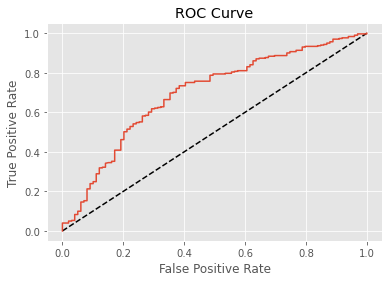

In [35]:
probs = gnb.predict_proba(test_x)[:,1]
# Generate the False Positive Rate and True Positive Rate Given different thresholds
fpr, tpr, thresholds = m.roc_curve(test_y, probs)

# Plot ROC curve
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

##### This means if we treat all our varibles as continuous, it will perform better than my algorithm.